In [ ]:
# Victor Z
# UW-Madison, 2024
# illustrate pdfs and cdfs for multivariate Gaussians
# used GPT to translate Matlab to Python file

In [ ]:
from scipy.stats import chi2, norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [ ]:
# define ellipse function
# adapted from ellipse.m - Copyright (C) 2001, James B. Rawlings and John W. Eaton

def ellipse(amat, level, n=100, shift=None):
    if shift is None:
        shift = np.array([0, 0])

    shift = np.asarray(shift)

    if shift.shape != (2,):
        if shift.shape == (2, 1):
            shift = shift.flatten()
        else:
            raise ValueError("shift must be a 2-element row vector")

    if amat.shape != (2, 2):
        raise ValueError("amat must be a 2x2 matrix")

    # Eigenvalues and eigenvectors
    vals, vecs = np.linalg.eig(amat / level)

    if np.any(np.iscomplex(vals)) or np.any(vals <= 0):
        raise ValueError("ellipse: amat must be positive definite")

    # Generate contour data
    a = 1 / np.sqrt(vals[0])
    b = 1 / np.sqrt(vals[1])

    t = np.linspace(0, 2 * np.pi, n)

    xt = a * np.cos(t)
    yt = b * np.sin(t)

    # Rotate the contours
    ra = np.arctan2(vecs[1, 0], vecs[0, 0])

    cos_ra = np.cos(ra)
    sin_ra = np.sin(ra)

    x = xt * cos_ra - yt * sin_ra + shift[0]
    y = xt * sin_ra + yt * cos_ra + shift[1]

    # Endpoints of the major and minor axes
    minor = vecs @ np.diag([a, b])
    major = np.copy(minor)

    major[:, 1] = -major[:, 0]
    minor[:, 0] = -minor[:, 1]

    major += shift
    minor += shift

    # Bounding box for the ellipse using magic formula
    ainv = np.linalg.inv(amat)
    xbox = np.sqrt(level * ainv[0, 0])
    ybox = np.sqrt(level * ainv[1, 1])

    bbox = np.array([
        [xbox, ybox],
        [xbox, -ybox],
        [-xbox, -ybox],
        [-xbox, ybox],
        [xbox, ybox]
    ])

    bbox += shift

    return x, y, major, minor, bbox


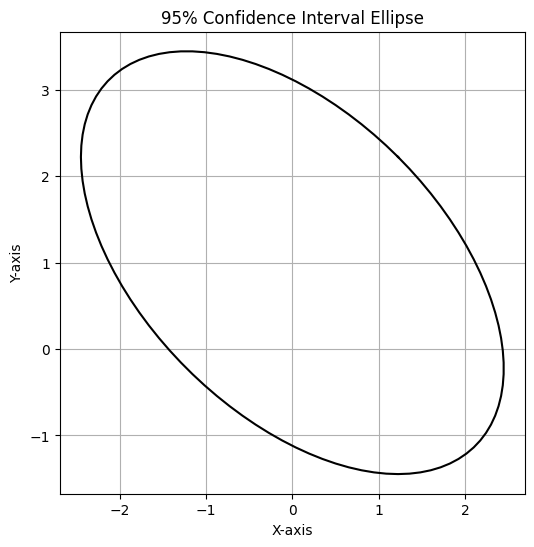

In [ ]:
# specify mean and covariance
mu = np.array([0, 1])
Sigma = np.array([[1, -0.5], [-0.5, 1]])  # anti-correlated

# peak density
fmu = 1 / ((2 * np.pi) * np.sqrt(np.linalg.det(Sigma)))

# compute the 95% confidence interval ellipse
alpha = 0.95  # confidence
n = 2  # dimension of variable
A = np.linalg.inv(Sigma)  # inverse covariance
b = chi2.ppf(alpha, n)  # confidence level on 2d from chi2 distribution

# Compute ellipse
xe, ye, major, minor, bbox = ellipse(A, b, 100, mu)

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(xe, ye, color='k')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('95% Confidence Interval Ellipse')
plt.grid(True)
plt.axis('equal')
plt.show()

In [ ]:
# 95% marginal intervals
b2 = chi2.ppf(alpha, 1)  # confidence level on 1d from chi2 distribution
xd2 = np.sqrt(b2 * np.diag(Sigma))  # confidence interval on 1d
mbox = np.tile(mu, (5, 1)) + np.array([[-xd2[0], -xd2[1]], [xd2[0], -xd2[1]], [xd2[0], xd2[1]], [-xd2[0], xd2[1]], [-xd2[0], -xd2[1]]])
print(mbox)

[[-1.95996398 -0.95996398]
 [ 1.95996398 -0.95996398]
 [ 1.95996398  2.95996398]
 [-1.95996398  2.95996398]
 [-1.95996398 -0.95996398]]


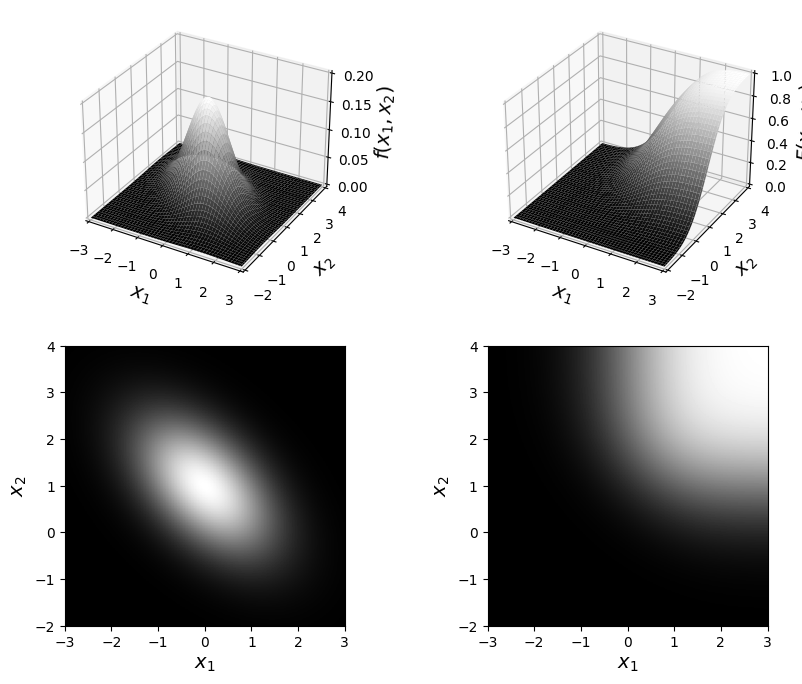

In [ ]:
# Assuming mu and Sigma are defined elsewhere

# Evaluate probability density function in domain (-3,3) and (-3,3)
nmesh = 100
x1 = np.linspace(-3, 3, nmesh)
x2 = np.linspace(-2, 4, nmesh)
X1, X2 = np.meshgrid(x1, x2)
mesh_points = np.column_stack([X1.ravel(), X2.ravel()])

f = multivariate_normal.pdf(mesh_points, mean=mu, cov=Sigma)
f = f.reshape(len(x2), len(x1))

# Visualize joint pdf and cdf
fig = plt.figure(figsize=(10, 8))

# Joint PDF
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X1, X2, f, cmap='gray')
ax1.set_xlabel('$x_1$', fontsize=14)
ax1.set_ylabel('$x_2$', fontsize=14)
ax1.set_zlabel('$f(x_1,x_2)$', fontsize=14)
ax1.set_xlim([-3, 3])
ax1.set_ylim([-2, 4])
ax1.set_zlim([0, 0.2])

# Joint CDF
F = multivariate_normal.cdf(mesh_points, mean=mu, cov=Sigma)
F = F.reshape(len(x2), len(x1))
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(X1, X2, F, cmap='gray')
ax2.set_xlabel('$x_1$', fontsize=14)
ax2.set_ylabel('$x_2$', fontsize=14)
ax2.set_zlabel('$F(x_1,x_2)$', fontsize=14)
ax2.set_xlim([-3, 3])
ax2.set_ylim([-2, 4])
ax2.set_zlim([0, 1])

# Projection of 2D PDF
ax3 = fig.add_subplot(223)
ax3.imshow(f, extent=[-3, 3, -2, 4], cmap='gray', origin='lower')
ax3.set_xlabel('$x_1$', fontsize=14)
ax3.set_ylabel('$x_2$', fontsize=14)
ax3.set_xlim([-3, 3])
ax3.set_ylim([-2, 4])

# Projection of 2D CDF
ax4 = fig.add_subplot(224)
ax4.imshow(F, extent=[-3, 3, -2, 4], cmap='gray', origin='lower')
ax4.set_xlabel('$x_1$', fontsize=14)
ax4.set_ylabel('$x_2$', fontsize=14)
ax4.set_xlim([-3, 3])
ax4.set_ylim([-2, 4])

#plt.tight_layout()
plt.show()

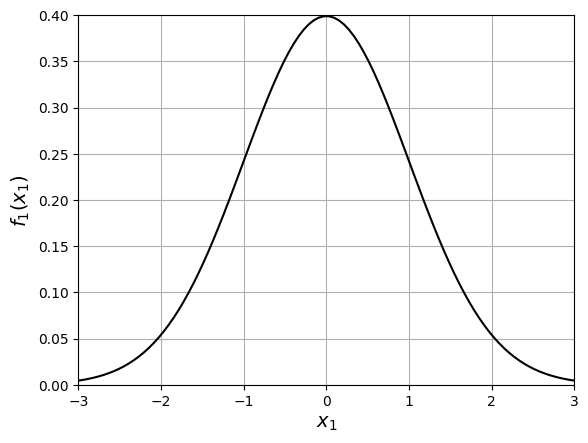

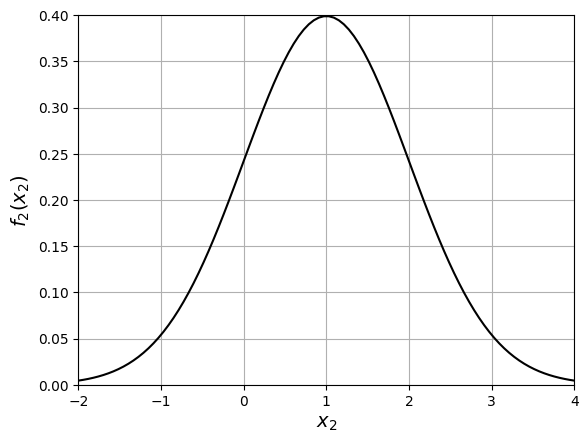

In [ ]:

# Visualize marginals
plt.figure(2)

f1 = norm.pdf(x1, mu[0], np.sqrt(Sigma[0, 0]))
plt.plot(x1, f1, 'black')
plt.grid(True)
plt.axis([-3, 3, 0, 0.4])
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$f_1(x_1)$', fontsize=14)

plt.figure(3)

f2 = norm.pdf(x2, mu[1], np.sqrt(Sigma[1, 1]))
plt.plot(x2, f2, 'black')
plt.grid(True)
plt.axis([-2, 4, 0, 0.4])
plt.xlabel('$x_2$', fontsize=14)
plt.ylabel('$f_2(x_2)$', fontsize=14)

plt.show()

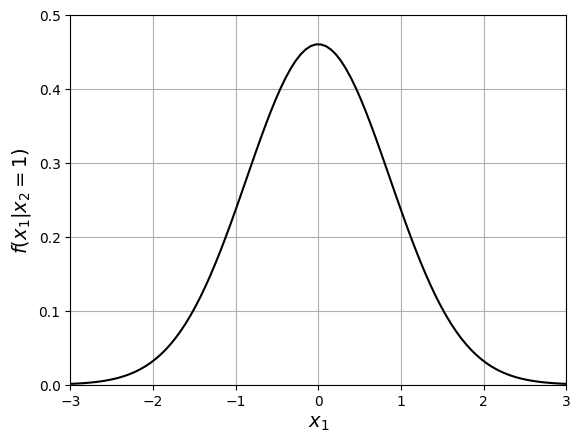

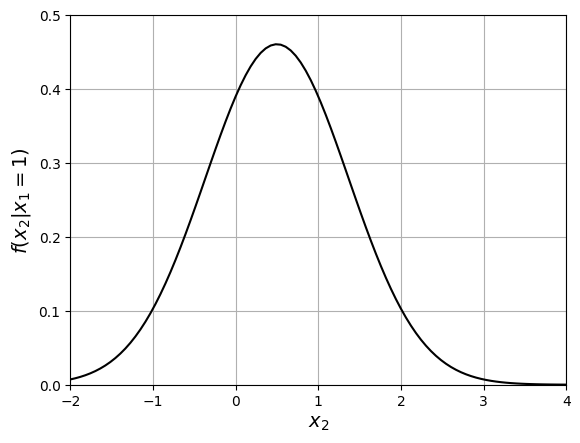

In [ ]:

# Visualize conditionals
x2p = 1
mu12 = mu[0] + Sigma[0, 1] * (1/Sigma[1, 1]) * (x2p - mu[1])
Sigma12 = Sigma[0, 0] - Sigma[0, 1] * (1/Sigma[1, 1]) * Sigma[1, 0]

x1p = 1
mu21 = mu[1] + Sigma[1, 0] * (1/Sigma[0, 0]) * (x1p - mu[0])
Sigma21 = Sigma[1, 1] - Sigma[1, 0] * (1/Sigma[0, 0]) * Sigma[0, 1]

plt.figure(4)

f12 = norm.pdf(x1, mu12, np.sqrt(Sigma12))
plt.plot(x1, f12, 'black')
plt.grid(True)
plt.axis([-3, 3, 0, 0.5])
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$f(x_1|x_2=1)$', fontsize=14)


plt.figure(5)

f21 = norm.pdf(x2, mu21, np.sqrt(Sigma21))
plt.plot(x2, f21, 'black')
plt.grid(True)
plt.axis([-2, 4, 0, 0.5])
plt.xlabel('$x_2$', fontsize=14)
plt.ylabel('$f(x_2|x_1=1)$', fontsize=14)

plt.show()